# Rakuten USA - Data Engineering Test

### Goal
The goal of this test is not ment to be exhaustive, but we do want to test your skills in analytical thinking, SQL, data wrangling, data analysis, and data visualization.

### Expectations
You can expect this test to use the following technologies:
- Python3
- Jupyter Notebook
- PySpark
- PySpark SQL

This test will cover the following areas: 
- Data cleaning/wrangling
- Exploratory Data Analysis (EDA)
- Data Visualization (Bonus)
- Lessons learned

This test should take you no more than 4 hours.

### What to turn in, and where to send your test
Please email stirling.waite@rakuten with your finished notebook
- rakuten_engineering_test.ipynb
 
### Questions?
Feel free to email me or call me with any questions about this test
- stirling.waite@rakuten.com
- 801-856-1426

# About The Dataset

Below you will find a free Kaggle competition dataset from https://www.kaggle.com/mayank811/employee-reviews/data using scraped data from Glassdoor.com.

## Context
- Over 67k employee reviews for Google, Amazon, Facebook, Apple, Microsoft, and Netflix.
- Web scraped from Glassdoor

## Content
This dataset contains employee reviews separated into the following categories:

- **Index:** index
- **Company:** Company name
- **Location:** This dataset is global, as such it may include the country's name in parenthesis [i.e "Toronto, ON(Canada)"]. However, if the location is in the USA then it will only include the city and state[i.e "Los Angeles, CA" ]
- **Date Posted:** in the following format MM DD, YYYY
- **Job-Title:** This string will also include whether the reviewer is a 'Current' or 'Former' Employee at the time of the review
- **Summary:** Short summary of employee review
- **Pros:** Pros
- **Cons:** Cons
- **Overall Rating:** 1-5
- **Work/Life Balance Rating:** 1-5
- **Culture and Values Rating:** 1-5
- **Career Opportunities Rating:** 1-5
- **Comp & Benefits Rating:** 1-5
- **Senior Management Rating:** 1-5
- **Helpful Review Count:** 1-5

**Link to Review:** This will provide you with a direct link to the page that contains the review. However it is likely that this link will be outdated

**NOTE:** 'none' is placed in all cells where no data value was found.



# PySpark Initialization

In [1]:
import re
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.sql import types as t
from pyspark.sql.types import *
from datetime import datetime

In [2]:
conf = SparkConf()\
                .setMaster("local[*]")\
                .setAppName("rakutenHomework")
        
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## Read Dataset into Spark

In [40]:
reviews_df = spark.read.csv("employee_reviews_usa.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print(reviews_df.count())
reviews_df.show()

27779
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|        dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|  Feb 8, 2015|Current Employee

# Data Cleaning & Removing Un-Needed Columns

No one likes dirty data.  Let's clean up this dataset to make it more usable for our use case.

 
1. Make the date field more data friendly
    - Hint #1: Use the provided `review_date_udf` udf provided (it will make your life more simple) 
2. Using the "location" column 
    - Add new columns for city, state, country columns
        - Hint #1: Concider using `fn.split()` to split `location` for columns `city` `state` 
        - Hint #2: I've narrowed down the country to just US, so please use something like below to create the `country` column
            - ```lit("US").alias("country")```
3. Using the "job-title" column  
    - Add a new boolean column titled "current_employee" that will show:
        - 1,  if reviewer is a current employee
        - 0,  if reviewer is not a current employee
        - Hint:  Use spark function `fn.when()` and `col("job-title").contains("")`
    - Remove "Former Employee - " and "" from the "job-title" column
        - Hint: Use the udf function `reg_job_title_udf`
4. Drop un-needed columns 
    - "_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location"

##### Useful UDF functions needed for below

In [43]:
review_date_udf = fn.udf(
    lambda x: datetime.strptime(x, ' %b %d, %Y'), DateType()
)

In [44]:
def reg_job_title(column):
    res_split=[]
    reg_patterns=["Former Employee - / ", "Current Employee - / "]
    for i in range(len(reg_patterns)):
        res_split=re.findall(r"[^/]+",reg_patterns[i])
        for x in res_split[0].split("|"):
            column = column.replace(x,res_split[1])
    return column[1:]

reg_job_title_udf = fn.udf(reg_job_title, t.StringType())

# Cleaned Spark Dataframe

- I've included the starting of dataframe, but in the `select` you will want to add the fixes and columns needed to answer the questions below


In [54]:
cleaned_reviews_df = reviews_df.where((col("dates") != 'None') & (col("dates") != ' Jan 0, 0000') & (col("dates") != ' Nov 0, 0000') & (~col("location").contains("(")) & (col("location") != "none")) \
                         .select(
                            col("company"),
                            (fn.split(col("location"), ", ")[0]).alias("city"),
                            (fn.split(col("location"), ", ")[1]).alias("state"),
                            lit("US").alias("country"),
                            review_date_udf(col('dates')).alias("review_date"),
                            reg_job_title_udf(col("job_title")).alias("job_title"),
                            fn.when(col("job_title").contains('Current'), 1).otherwise(0).alias("current_employee"),
                            col("overall_ratings"),
                            col("work_balance_stars"),
                            col("culture_values_stars"),
                            col("carrer_opportunities_stars"),
                            col("comp_benefit_stars"),
                            col("senior_mangemnet_stars"),
                            col("helpful_count")
                         )

cleaned_reviews_df.show()

+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
|company|         city|state|country|review_date|           job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|
+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
| google|Mountain View|   CA|     US| 2015-02-08|  Anonymous Employee|               1|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|          498|
| google|Mountain View|   CA|     US| 2018-12-09|                SDE2|               0|     

# Testing Questions

Each question below will have two parts.   Please solve each problem in PySpark and PySpark SQL.  This is to test your ability to solve the problems in PySpark, and in SQL.

- PySpark API: https://spark.apache.org/docs/latest/api/python/index.html
- PySpark SQL API: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

In [61]:
cleaned_reviews_df.createOrReplaceTempView("reviews")

### (1) What is the total number of reviews in the data set?

##### PySpark Implmentation

In [47]:
cleaned_reviews_df.count()

27779

##### Spark SQL Implmentation

In [48]:
spark.sql("SELECT count(*) as review_count from reviews").show()

+------------+
|review_count|
+------------+
|       27779|
+------------+



###  (2) How many reviews exist in the dataset per each company?

##### PySpark Implmentation

In [49]:
company_reviews = cleaned_reviews_df.select("company").groupBy('company').count().orderBy('count', ascending=[0])
company_reviews.show()

+---------+-----+
|  company|count|
+---------+-----+
|   amazon| 9993|
|microsoft| 7919|
|    apple| 5729|
|   google| 2546|
| facebook| 1148|
|  netflix|  444|
+---------+-----+



##### Spark SQL Implmentation

In [13]:
spark.sql("""SELECT 
                company,
                count(*) as review_count 
             from reviews
             group by company
             order by review_count DESC
           """
         )\
         .show()

+---------+------------+
|  company|review_count|
+---------+------------+
|   amazon|        9993|
|microsoft|        7919|
|    apple|        5729|
|   google|        2546|
| facebook|        1148|
|  netflix|         444|
+---------+------------+



###  (3) How many reviews (former and current) per each company are in the dataset?

##### PySpark Implmentation

In [14]:
company_current_reviews = cleaned_reviews_df.select(
                                                col("company"), 
                                                col("current_employee")
                                             ) \
                                             .groupBy(['company', 'current_employee']) \
                                             .count() \
                                             .orderBy(['company','count'])
company_current_reviews.show()

+---------+----------------+-----+
|  company|current_employee|count|
+---------+----------------+-----+
|   amazon|               0| 3341|
|   amazon|               1| 6652|
|    apple|               0| 2377|
|    apple|               1| 3352|
| facebook|               0|  217|
| facebook|               1|  931|
|   google|               0|  926|
|   google|               1| 1620|
|microsoft|               0| 2790|
|microsoft|               1| 5129|
|  netflix|               0|  214|
|  netflix|               1|  230|
+---------+----------------+-----+



##### Spark SQL Implmentation

In [15]:
spark.sql("""SELECT 
                company,
                current_employee,
                count(*) as review_count 
             from reviews
             group by company, current_employee
             order by company, review_count ASC
           """
         )\
         .show()

+---------+----------------+------------+
|  company|current_employee|review_count|
+---------+----------------+------------+
|   amazon|               0|        3341|
|   amazon|               1|        6652|
|    apple|               0|        2377|
|    apple|               1|        3352|
| facebook|               0|         217|
| facebook|               1|         931|
|   google|               0|         926|
|   google|               1|        1620|
|microsoft|               0|        2790|
|microsoft|               1|        5129|
|  netflix|               0|         214|
|  netflix|               1|         230|
+---------+----------------+------------+



###  (4) What is the average review scores of each current and former employees for each company?

##### PySpark Implmentation

In [16]:
company_current_avg_review_scores = cleaned_reviews_df.select(
                                                            col("company"), 
                                                            col("current_employee"),
                                                            col("overall_ratings")
                                                         ) \
                                                         .groupBy(['company', 'current_employee']) \
                                                         .agg(avg(col("overall_ratings")).alias("avg_overall_rating")) \
                                                         .orderBy(['company', 'avg_overall_rating'], ascending=[1,0])
company_current_avg_review_scores.show()

+---------+----------------+------------------+
|  company|current_employee|avg_overall_rating|
+---------+----------------+------------------+
|   amazon|               1|3.7118159951894167|
|   amazon|               0|2.9811433702484287|
|    apple|               1| 4.077267303102626|
|    apple|               0| 3.830037862852335|
| facebook|               1| 4.703544575725027|
| facebook|               0|3.9262672811059907|
|   google|               1| 4.430864197530864|
|   google|               0| 4.155507559395248|
|microsoft|               1|3.8619613959836228|
|microsoft|               0|3.5612903225806454|
|  netflix|               1| 3.965217391304348|
|  netflix|               0|  2.94392523364486|
+---------+----------------+------------------+



##### Spark SQL Implmentation

In [17]:
spark.sql("""SELECT 
                company,
                current_employee,
                avg(overall_ratings) AS avg_overall_rating
             from reviews
             group by company, current_employee
             order by company, avg_overall_rating DESC
           """
         )\
         .show()

+---------+----------------+------------------+
|  company|current_employee|avg_overall_rating|
+---------+----------------+------------------+
|   amazon|               1|3.7118159951894167|
|   amazon|               0|2.9811433702484287|
|    apple|               1| 4.077267303102626|
|    apple|               0| 3.830037862852335|
| facebook|               1| 4.703544575725027|
| facebook|               0|3.9262672811059907|
|   google|               1| 4.430864197530864|
|   google|               0| 4.155507559395248|
|microsoft|               1|3.8619613959836228|
|microsoft|               0|3.5612903225806454|
|  netflix|               1| 3.965217391304348|
|  netflix|               0|  2.94392523364486|
+---------+----------------+------------------+



###  (5) Show the count of former Google employee reviews and the average work_balance_score in locations Seattle, San Francisco, or Utah
- Please show in one solution  

##### PySpark Implmentation

In [65]:
reviews_by_location_work_balance = cleaned_reviews_df.select(
                                                        col("company"),
                                                        col("city"),
                                                        col("state"),
                                                        col("country"),
                                                        col("current_employee"),
                                                        col("work_balance_stars")
                                                    ) \
                                                    .where((col("current_employee").contains(0)) & ((col("state") == "UT") | (col("city") == "San Francisco") | (col("city") == "Seattle"))) \
                                                    .groupBy(["company", "city", "state"]) \
                                                    .agg(
                                                        fn.count(fn.lit(1)).alias("review_count"),
                                                        avg(col("work_balance_stars")).alias("work_balance_stars_avg")
                                                    ) \
                                                    .orderBy(['work_balance_stars_avg', 'review_count'], ascending=[0, 0])
                
reviews_by_location_work_balance.show(25)

+---------+--------------+-----+------------+----------------------+
|  company|          city|state|review_count|work_balance_stars_avg|
+---------+--------------+-----+------------+----------------------+
|microsoft|       Redmond|   UT|           2|                   5.0|
|microsoft|        Murray|   UT|           2|                   5.0|
|   google|         Kanab|   UT|           1|                   5.0|
|    apple|        Murray|   UT|           1|                   5.0|
|    apple|     Bountiful|   UT|           1|                   5.0|
|   google| San Francisco|   CA|          71|     4.345588235294118|
|    apple|Salt Lake City|   UT|          15|     4.153846153846154|
|    apple|        Layton|   UT|           1|                   4.0|
|   google|       Seattle|   WA|          19|    3.5294117647058822|
| facebook| San Francisco|   CA|          11|                   3.5|
|microsoft|Salt Lake City|   UT|           4|                   3.5|
|microsoft| San Francisco|   CA|  

##### Spark SQL Implmentation

In [64]:
spark.sql("""SELECT 
                company,
                city,
                state,
                country,
                count(*) AS review_count,
                avg(work_balance_stars) AS work_balance_stars_avg
             from reviews
             WHERE current_employee = 0 and (state = "UT" or city = 'San Francisco' or city = 'Boston')
             group by company, city, state, country
             order by work_balance_stars_avg DESC, review_count DESC
           """
         )\
         .show(25)

+---------+--------------+-----+-------+------------+----------------------+
|  company|          city|state|country|review_count|work_balance_stars_avg|
+---------+--------------+-----+-------+------------+----------------------+
|microsoft|       Redmond|   UT|     US|           2|                   5.0|
|microsoft|        Murray|   UT|     US|           2|                   5.0|
|    apple|     Bountiful|   UT|     US|           1|                   5.0|
| facebook|        Boston|   MA|     US|           1|                   5.0|
|   google|         Kanab|   UT|     US|           1|                   5.0|
|    apple|        Murray|   UT|     US|           1|                   5.0|
|   google|        Boston|   MA|     US|           5|                   4.6|
|   google| San Francisco|   CA|     US|          71|     4.345588235294118|
|    apple|Salt Lake City|   UT|     US|          15|     4.153846153846154|
|    apple|        Layton|   UT|     US|           1|                   4.0|

# Visualize Your Data
1. Turn your Spark dataframe into a Pandas dataframe
    - https://pandas.pydata.org/
2. Answer the visualization questions with any of the following libraries:
    - Matplotlib (https://matplotlib.org/)
    - Seaborn (https://seaborn.pydata.org/introduction.html)
    - Bookeh (https://bokeh.pydata.org/en/latest/)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [21]:
reviews_pd_df = cleaned_reviews_df.toPandas()
print(reviews_pd_df)

         company           city state country review_date  \
0         google  Mountain View    CA      US  2015-02-08   
1         google  Mountain View    CA      US  2018-12-09   
2         google       New York    NY      US  2018-12-11   
3         google       New York    NY      US  2018-12-10   
4         google  Mountain View    CA      US  2018-12-08   
5         google  San Francisco    CA      US  2018-12-03   
6         google       New York    NY      US  2018-11-26   
7         google    Los Angeles    CA      US  2018-11-29   
8         google  San Francisco    CA      US  2018-11-17   
9         google  Mountain View    CA      US  2018-12-09   
10        google  Mountain View    CA      US  2018-12-08   
11        google       Dearborn    MI      US  2018-11-20   
12        google       New York    NY      US  2018-12-06   
13        google      Sunnyvale    CA      US  2018-11-21   
14        google        Seattle    WA      US  2018-11-13   
15        google       N

### Plot the distribution of reviewers who are current and former employees
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

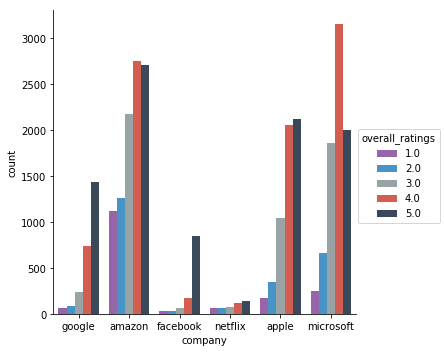

In [22]:
sns.factorplot(x='company', data=reviews_pd_df, hue='overall_ratings', palette=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], kind='count', size=5, aspect=1)

### Plot the distributions of reviews for each company (current and former employees) and their overall ratings
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

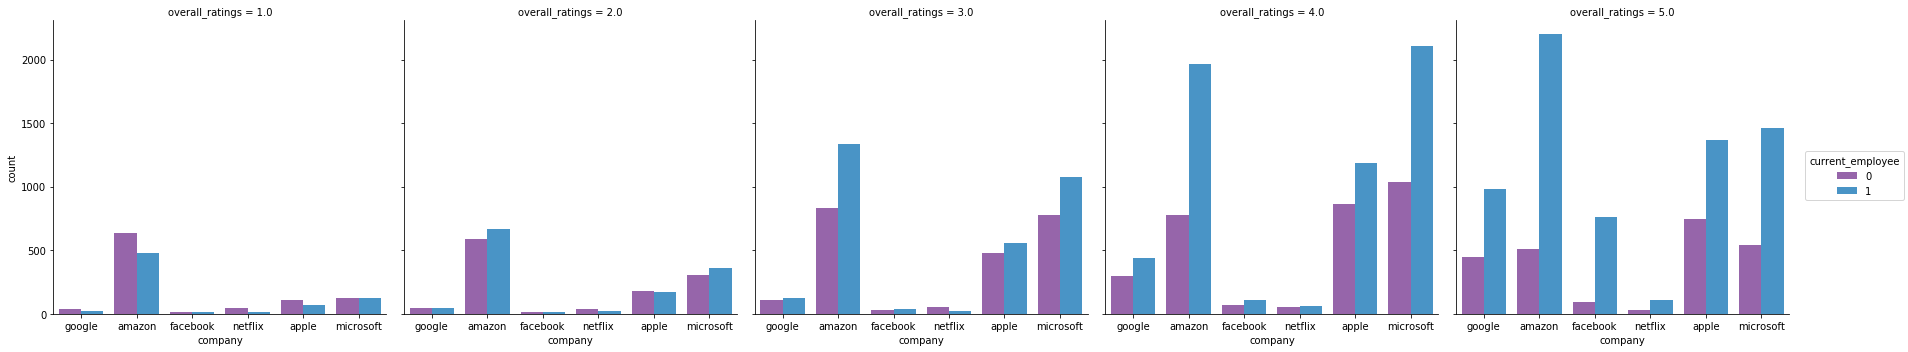

In [23]:
sns.factorplot(x='company', hue='current_employee', data=reviews_pd_df, col='overall_ratings', kind='count', palette=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], size=5, aspect=1)

In [25]:
pd.crosstab(index=[reviews_pd_df.company, reviews_pd_df.overall_ratings], columns=[reviews_pd_df.current_employee], margins=True)

current_employee              0      1    All
company   overall_ratings                    
amazon    1.0               634    480   1114
          2.0               588    669   1257
          3.0               832   1337   2169
          4.0               781   1968   2749
          5.0               506   2198   2704
apple     1.0               107     70    177
          2.0               177    169    346
          3.0               478    559   1037
          4.0               866   1188   2054
          5.0               749   1366   2115
facebook  1.0                15     14     29
          2.0                15     13     28
          3.0                31     36     67
          4.0                66    109    175
          5.0                90    759    849
google    1.0                36     22     58
          2.0                43     46     89
          3.0               106    128    234
          4.0               297    440    737
          5.0               444    984   1428
microsoft 1.0               127    122    249
          2.0               304    362    666
          3.0               778   1077   1855
          4.0              1038   2109   3147
          5.0               543   1459   2002
netflix   1.0                45     14     59
          2.0                36     25     61
          3.0                51     21     72
          4.0                50     65    115
          5.0                32    105    137
All                        9865  17914  27779

# Open Ended Question

### Problem
We have time series data in a Kafka topic.  The data has a primary key of user_id and each user_id will have between 1-1000 records with different event timestamps and a JSON payload.  We would like to store this data in both HDFS and HBase.  The system will have peak inbound transactions of 20,000 events / second. 

### Requirements
We would like to pull a user timeline in less than 50ms. A timeline is all events for that primary key sorted by time.
We would like to keep a summary profile of each primary key kept up to date real (or near real-time). Counts of occurrences, last event, counts based on JSON payload attributes.
We need to run analytics using Hive / Spark on ad-hoc basis.

### Delivery from Assignment  
1. At least TWO solutions to ingest the data using differing technologies.  Explain pros and cons of each.   Performance, complexity, risk, supportability etc.  This needs to be detailed down to the libraries / languages used, storage schema / partitioning / formats. We DON’T need to see working code
2. Details of monitoring and health checks that would be appropriate to ensure all is well with running solution
3. Estimation of resource and time required to implement your preferred solution for each component.
4. Max time 2 hours. 

### Assessment Criteria
1. We will walk through the designs  prior to verbally discussing your thought processes on your proposals